In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import keras
from keras import layers
import scipy.optimize

tf.random.set_seed(2727)
np.random.seed(2727)

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Heat Equation with Dirichlet boundary conditions on $[0,T]\times[0,c]$:

\begin{align}
\partial_t u(t,x) &= \partial^2_{xx}u(t,x) \\
u(0,x) &= \varphi(x)\\
u(t,0) &= 0\\
u(t,c) &= 0 
\end{align}

Here time-space is modeled by $(t,x)\in[0,T]\times[0,c]$, thus $u\colon[0,T]\times[0,c]\to \R$


In [2]:
class Network:
    def __init__(self, input_dim) -> None:
        self.input_dim = input_dim

    def build(self):
        nn = keras.Sequential(
        [
            layers.Input(shape=(self.input_dim,)),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(1, kernel_initializer='he_normal', use_bias=False),
        ])
        return nn


In [3]:
class HeatModel:
    # 1D Heat equation PINN-solver. It contains its own nn.
    def __init__(self):

        self.learning_rate = 0.001
        self.model = Network(2).build()
    
    def init_condition(self, data):
        batch_size = data.shape[0]
        return (data[...,1]**2 * (2-data[...,1])).reshape((batch_size, 1))
    
    ##################### LOSS METHODS ###########################

    def pde_loss(self, data):

        # Error given by the PDE over data.
        
        z = tf.Variable(data, trainable=False)
        with tf.GradientTape() as tape2:
            tape2.watch(z)
            with tf.GradientTape() as tape1:
                tape1.watch(z)
                u = self.model(z)
            u_z = tape1.batch_jacobian(u, z)
        u_zz = tape2.batch_jacobian(u_z, z)
        u_t = u_z[...,0,0]
        u_xx = u_zz[...,0,1,1]
        return tf.reduce_mean(tf.math.square(u_t - u_xx))

    def boundary_loss(self, data_init, data_left, data_right):
        l1 = tf.reduce_mean(tf.math.square(self.model(data_left)))
        l2 = tf.reduce_mean(tf.math.square(self.model(data_right)))
        l3 = tf.reduce_mean(tf.math.square(self.model(data_init) - self.init_condition(data_init)))
        return l1 + l2 + l3
    
    def total_loss(self, data_int, data_init, data_left, data_right):
        #self.pde_loss(data_int) + 
        return self.boundary_loss(data_init, data_left, data_right)
    ##################### TRAINING METHODS ###########################
    
    def gradients(self, data_int, data_init, data_left, data_right):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            target = self.total_loss(data_int, data_init, data_left, data_right)
        return target, tape.gradient(target, self.model.trainable_variables)

    def fit(self, data_int, data_left, data_right):
        pass

            

In [4]:
heat_model = HeatModel()

In [5]:
# batch_size
n = 1000
# Interior data
data_int = np.random.rand(n,2) * 2
# t=0 data
data_init = np.random.rand(n,2) * 2
data_init[..., 0] = 0
# x = 0 data
data_left = np.random.rand(n,2) * 2
data_left[..., 1] = 0
# x = 2 data
data_right = np.random.rand(n,2) * 2
data_right[..., 1] = 2


In [6]:
l = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
b = 32
for epoch in range(15):
    for i in tqdm(range(n - b)):
        target, gradients = heat_model.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
        #heat_model.apply_gradients(gradients)
        optimizer.apply_gradients(zip(gradients, heat_model.model.trainable_variables))
    print(f'epoch n°: {epoch}')
    l.append(target)

100%|██████████| 968/968 [00:20<00:00, 47.76it/s]


epoch n°: 0


100%|██████████| 968/968 [00:20<00:00, 46.55it/s]


epoch n°: 1


100%|██████████| 968/968 [00:20<00:00, 47.76it/s]


epoch n°: 2


100%|██████████| 968/968 [00:20<00:00, 48.04it/s]


epoch n°: 3


100%|██████████| 968/968 [00:20<00:00, 48.26it/s]


epoch n°: 4


100%|██████████| 968/968 [00:20<00:00, 48.30it/s]


epoch n°: 5


100%|██████████| 968/968 [00:19<00:00, 48.85it/s]


epoch n°: 6


100%|██████████| 968/968 [00:19<00:00, 48.93it/s]


epoch n°: 7


100%|██████████| 968/968 [00:19<00:00, 48.79it/s]


epoch n°: 8


100%|██████████| 968/968 [00:19<00:00, 48.41it/s]


epoch n°: 9


100%|██████████| 968/968 [00:20<00:00, 48.26it/s]


epoch n°: 10


100%|██████████| 968/968 [00:20<00:00, 48.04it/s]


epoch n°: 11


100%|██████████| 968/968 [00:20<00:00, 48.16it/s]


epoch n°: 12


100%|██████████| 968/968 [00:20<00:00, 48.11it/s]


epoch n°: 13


100%|██████████| 968/968 [00:20<00:00, 47.76it/s]

epoch n°: 14


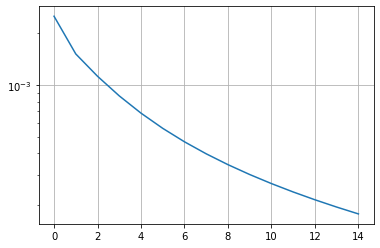

In [7]:
plt.plot(l)
plt.grid()
plt.yscale("log")

In [8]:
z = np.arange(0,2 + 0.01,0.01)
a0 = np.array([[0.0,x] for x in z])
a1 = np.array([[0.5,x] for x in z])
a2 = np.array([[1,x] for x in z])
a3 = np.array([[1.5,x] for x in z])

In [9]:
b0 = heat_model.model(a0)[...,0].numpy()
b1 = heat_model.model(a1)[...,0].numpy()
b2 = heat_model.model(a2)[...,0].numpy()
b3 = heat_model.model(a3)[...,0].numpy()



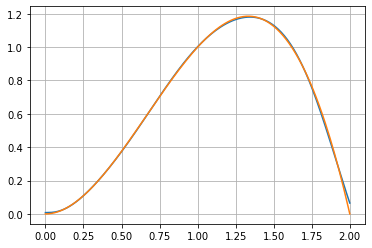

In [10]:
plt.plot(z, b0)
plt.plot(z, heat_model.init_condition(a0))
plt.grid()